In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
plt.style.use("Solarize_Light2")


In [2]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

## Decision Tree:
### Introduction:
A decision tree model builds classification or regression models in a tree structure. It breaks down a dataset into
smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final
result is a tree with decision nodes and leaf nodes.

### First Iteration:

In [3]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

y_pred_dt = decision_tree.predict(X_test)
y_pred_train_dt = decision_tree.predict(X_train)

Accuracy score for test data : 0.7289961223610513
Accuracy score for train data : 1.0
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1711
           1       0.49      0.52      0.50       610

    accuracy                           0.73      2321
   macro avg       0.66      0.66      0.66      2321
weighted avg       0.74      0.73      0.73      2321



<AxesSubplot:>

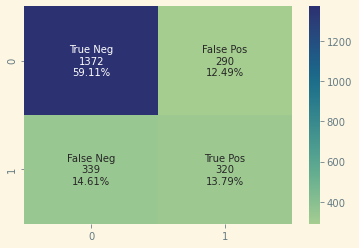

In [4]:
dt_as = metrics.accuracy_score(y_test, y_pred_dt)
dt_as_train = metrics.accuracy_score(y_train, y_pred_train_dt)

print(f"Accuracy score for test data : {dt_as}")
print(f"Accuracy score for train data : {dt_as_train}")

print(metrics.classification_report(y_test, y_pred_dt))

cf_matrix = metrics.confusion_matrix(y_pred_dt, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

Our initial model accuracy of 0.73 isn't bad, I'm particularly impressed by our initial recall score of 0.53 for
positive churn prediction. Let's tune the hyperparameters of our model and see if we can gain any improvements in our
metrics.

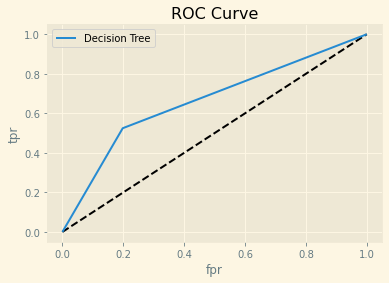

In [5]:
y_proba = decision_tree.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

In [6]:
"""
param_dict = {"criterion":['gini', 'entropy'],
              "max_depth":range(1,10),
              "min_samples_split":range(1,10),
              "min_samples_leaf":range(1,5)}

grid = GridSearchCV(decision_tree,
                    param_grid=param_dict,
                    verbose=0)

grid.fit(X_train, y_train)
grid.best_params_
"""

'\nparam_dict = {"criterion":[\'gini\', \'entropy\'],\n              "max_depth":range(1,10),\n              "min_samples_split":range(1,10),\n              "min_samples_leaf":range(1,5)}\n\ngrid = GridSearchCV(decision_tree,\n                    param_grid=param_dict,\n                    verbose=0)\n\ngrid.fit(X_train, y_train)\ngrid.best_params_\n'

### Second Iteration:

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1711
           1       0.59      0.61      0.60       610

    accuracy                           0.79      2321
   macro avg       0.73      0.73      0.73      2321
weighted avg       0.79      0.79      0.79      2321



<AxesSubplot:>

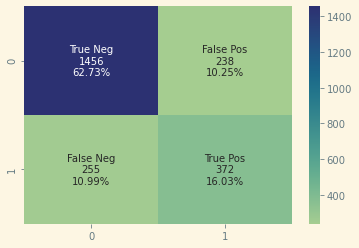

In [7]:
decision_tree_hp = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2, min_samples_split=6)
decision_tree_hp.fit(X_train, y_train)

y_pred_dt_hp = decision_tree_hp.predict(X_test)
y_pred_train_dt_hp = decision_tree_hp.predict(X_train)

print(metrics.classification_report(y_test, y_pred_dt_hp))

cf_matrix = metrics.confusion_matrix(y_pred_dt_hp, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

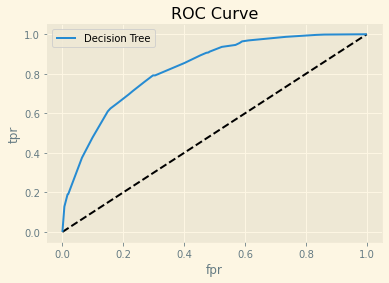

In [8]:
y_proba = decision_tree_hp.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Decision Tree')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

After updating our Decision Tree model with tuned hyperparameters, our results look much better.

##### Recall:
Our positive churn recall score has increased by 0.10 from 0.51 to 0.61, which is a great boost, especially considering the importance
of recall when our goal is to maximize positive churn prediction.
##### Accuracy:
Increased by 0.06 from 0.73 to 0.79, while not stellar it's a fairly reasonable level.

In [9]:
k = 5
kf = KFold(n_splits=k, random_state=None)

result = cross_val_score(decision_tree_hp ,X, y, cv = kf)
mean = round(result.mean()*100, 2)
stdv = round(result.std()*100, 2)
range = [round(mean-stdv, 2), round(mean+stdv ,2)]

print("Avg accuracy: {}% +/- {}%\n range: {}".format(mean, stdv, range))




Avg accuracy: 79.37% +/- 0.61%
 range: [78.76, 79.98]
